# Ant Rules

1. Ants can only move left or right when traversing forward or backward. For example, if an ant is moving North-East, it can only move to blocks directly north or directly east.

1. Ants lay pheromones when leaving the nest and returning to the nest with food
 1. The ants do not lay pheromones when not moving
 1. The ants lay more pheromones when returning with food versus foraging. The paper indicates 10x as much pheromone.
 
1. There is a maximum number of ants that can occupy a single point. 
 1. If an ant can't move to any valid location, it must remain in it's current location. 
 1. Will's rule: There is no occupancy limit for points in the nest.
 
1. For every step, a percentage of pheromone evaporates from each point.

1. Ants will choose their next location based on the amount of pheromone at each point.
 1. Ants can choose not to move if there is not enough pheromone in front of them (sigmoid relationship).

1. Will's Rule: If an ant finds food it switches direction (NE -> SW, etc)

1. Will's Rule: When ants return home, there is a large probability that they remain home.
 1. Instead of creating all of the agents at once, the authors decided that a fixed amount of ants will be created and leave the nest at each time step. The rule above mimics this rule by only letting out a small percentage of ants at the beginning and avoids the problem of trying to dynamically make/remove agents.
 
# To Do

1. See note about rule 7. We should try a model that constantly outputs a fixed amount of agents from the nest. The number of ants created every step should stop after ants return with food and leave to get more food.

1. Extension(s)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import basename, exists
import random
from scipy.special import expit

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

from utils import decorate, savefig
from scipy.signal import correlate2d

from Cell2D import Cell2D, draw_array

In [2]:
def make_locs(n, m, array):
    """Makes array where each row is an index in an `n` by `m` grid.
    
    n: int number of rows
    m: int number of cols
    
    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m) if array[i, j] >= 1]
    return np.array(t)

def make_visible_locs(direction):
    """Computes the kernel of visible cells.
        
    direction: ant facing direction
    """
    if direction == "SE":
        return np.array([[-1, 0], [0, 1]])
    elif direction == "SW":
        return np.array([[-1, 0], [0, -1]])
    elif direction == "NW":
        return np.array([[1, 0], [0, -1]])
    else:
        return np.array([[1,0], [0,1]])
    
def flip_directions(direction):
    if direction == "NE":
        return "SW"
    elif direction == "NW":
        return "SE"
    elif direction == "SW":
        return "NE"
    else:
        return "NW"

In [207]:
class Antscape(Cell2D):
    
    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        
        #parameters
        self.ant_per_cell_max = self.params.get('ants_per_cell', 1)
        self.sigmoid_offset = self.params.get('sigmoid_offset', 1)
        self.nest_size = self.params.get('nest_size', 100)
        self.ants_per_step = self.params.get('ants_per_step', 10)
        self.p_decay = self.params.get('p_decay', .95)
        self.starting_loc = self.params.get('starting_loc', (0,0))
        self.starting_dir = self.params.get('starting_dir', 'NE')

        # environment food capacity and probability of spawning variables
        self.food_capacity = self.params.get('food_capacity', 400)
        self.food_generation_prob = self.params.get('food_generation_prob', 0.95)
        # pheromone limit on a tile
        self.plimit = self.params.get('plimit', 100)

        # initially all cells are empty
        self.array = self.make_env()
        
        #location array
        self.larray = np.zeros([n,n])
        
        # pheromone array
        self.parray = np.ones([n,n])
        
        # make the agents
        self.make_agents()
        
    
    def make_env(self):
        """
        creates food and nest in the environment and returns the grid as np array

        square with food >= 1
        square with nest = -1
        """
        array = np.random.rand(self.n, self.n)
        
        # make food
        array[array >= self.food_generation_prob] = self.food_capacity
        array[array < self.food_generation_prob] = 0
                
        # make nest
        if self.starting_dir == 'NE':
            array[:self.starting_loc[0]+1, :self.starting_loc[1]+1] = -1
        elif self.starting_dir == 'SW':
            array[self.starting_loc[0]:, self.starting_loc[1]:] = -1
                
        return array

        
    def make_agents(self):
        """Makes the agents.
        """
        num_agents = self.params.get('starting_ants', 10)
        
        starting_direction = self.params.get('starting_direction', 'NE')
        self.agents = [Agent(self.starting_loc, starting_direction, self.params) for _ in range(num_agents)]
        
        # keep track of which cells are occupied
        for agent in self.agents:
            self.larray[agent.loc] += 1
            

    def find_food(self, center):
        """Checks if there is any food at a given location
        """
        if self.array[center] > 0:
            self.array[center] -= 1
            return True
        else:
            return False
    

    def find_nest(self, center):
        """Checks if center is in the nest
        """
        return self.array[center] == -1
        

    def p_deposit(self, center, p):
        """deposits pheromones at a given location
        """
        self.parray[center] += p
        # check limits
        if self.parray[center] > self.plimit:
            self.parray[center] = self.plimit

    
    def look_and_move(self, center, direction, has_food):
        """
        Finds available locations for agent, picks a location based on pheromone weights,
        decides whether agent moves based on a sigmoid function.
        """
        
        """
        TODO:
        movement code for ants that have food and want to return home.
        
        Arriving at the nest, it lays down the food item and return outward once more. (Note that should
        there be at any point no guiding pheromone in front of them, they move toward the central trail,
        although this rule is only rarely invoked.) 
        """
            
        # find all cells ant can move to and deals with edge cases
        locs = make_visible_locs(direction)
        locs = (locs + center) % self.n  
        # print(center, locs)
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        # select cells that are not too full or that are part of the nest
        # TODO: check second conditional, used to be == 2
        empty_locs = [loc for loc in locs if ((self.larray[loc] < self.ant_per_cell_max) or (self.array[loc] == -1))]

        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the pheromone level in each cell
        p_levels = [self.parray[loc] for loc in empty_locs]
        
        new_loc = random.choices(empty_locs, weights=p_levels)[0]
        
        # FOR ANTS RETURNING WITH FOOD, ONLY RETURN new_loc IF PHEROMONE
        #LEVELS ARE ABOVE A CERTAIN LEVEL. IF NOT, MOVE TOWARDS CENTER DIAGONAL
        # TODO: CHECK THIS
        if has_food and self.parray[new_loc] < 1.5:
            # if left of diag: 
            if (center[1] > center[0]):
                new_loc = (center[0], center[1]-1)
            
            # if right of diag:
            else:
                new_loc = (center[0], center[1]+1)
            return new_loc

                
        # decide whether to move to new location
        move_prob = expit(self.parray[new_loc] - self.sigmoid_offset)
        
        if np.random.rand() <= move_prob:
            return new_loc
        else:
            return center
            
        
    def step(self):
        """Executes one time step."""
        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        
        #decrease pheromone levels
        self.parray *= self.p_decay
        self.parray[self.parray < 1] = 1
#         self.parray += .01
        
        for agent in random_order:
            # mark the current cell unoccupied
            self.larray[agent.loc] -= 1
            
            # execute one step
            agent.step(self)
            
            # remove agents on edge of map
            if (agent.loc[0] % self.n == 0) or (agent.loc[1] % self.n == 0):
                self.agents.remove(agent)
            else:
                #mark ants's new cell as occupied
                self.larray[agent.loc] += 1
        
        #add new agents
        if len(self.agents) < self.nest_size:
            self.add_agents(min(self.ants_per_step, self.nest_size - len(self.agents)))
            
        
        return len(self.agents)
    
    
    def add_agents(self, size):
        """Generates a new agent.
                
        returns: new Agent
        """
        for i in range(size):
            new_agent = Agent(self.starting_loc, self.starting_dir, self.params)
            self.agents.append(new_agent)
            self.larray[new_agent.loc] += 1
        return new_agent
    
    
    def draw(self):
        """Draws the cells."""
        plt.figure(figsize=(5,5))
        draw_array(self.array, cmap='Blues', vmax=10, origin='lower')
        # draw occupied cells
        locs = make_locs(self.n, self.n, self.larray)
        xs, ys = self.get_coords(locs)
        self.points = plt.plot(xs, ys, ',', color='black')[0]
        
    def draw_verbose(self):
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1), plt.title("Food")
        draw_array(self.array, cmap='Blues', vmax=3, origin='lower')
        plt.subplot(1,3,2), plt.title("Ants")
        draw_array(self.larray, cmap="Greys", vmax=self.ant_per_cell_max, origin='lower')
        plt.subplot(1,3,3), plt.title("Pheromones")
        draw_array(self.parray, cmap='Purples', vmax=10, origin='lower')
        
        
    def get_coords(self, locs):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        locs = list(locs)
        rows, cols = np.transpose(locs)
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

In [208]:
class Agent:
    
    def __init__(self, loc, direction, params):

        self.loc = tuple(loc)
        self.has_food = False
        self.is_home = True
        self.direction = direction
        self.p_foraging  = params.get('p_foraging', 1)
        self.p_returning = params.get('p_returning',10)
    

    def step(self, env):
        
        old_loc = self.loc
        
        #look for food
        if env.find_food(self.loc) and not self.has_food:
            self.direction = flip_directions(self.direction)
            self.has_food = True
        
        #look for nest
        if env.find_nest(self.loc):
            if not self.is_home and self.has_food:
                self.direction = flip_directions(self.direction)
                self.has_food = False
                self.is_home = True
        else:
            self.is_home = False
        
        #move agent if it doesn't want to stay home
        self.loc = env.look_and_move(self.loc, self.direction, self.has_food)
        
        #lay pheremone (only if you move)
        if old_loc != self.loc:
            if self.has_food:
                p = self.p_returning
            else:
                p = self.p_foraging
                
            env.p_deposit(self.loc, p)


In [209]:
env = Antscape(500, starting_ants=40, ants_per_cell=10, ants_per_step=5, starting_loc=(9,9), starting_dir='NE',
               sigmoid_offset=2, nest_size=2000, p_foraging=1, p_returning=5, p_decay=.95,
               plimit=100, food_generation_prob=.97, food_capacity=50)

In [210]:
import time
start = time.time()
for i in range(1000):
    env.step()
env.draw()
time.time() - start

KeyboardInterrupt: 

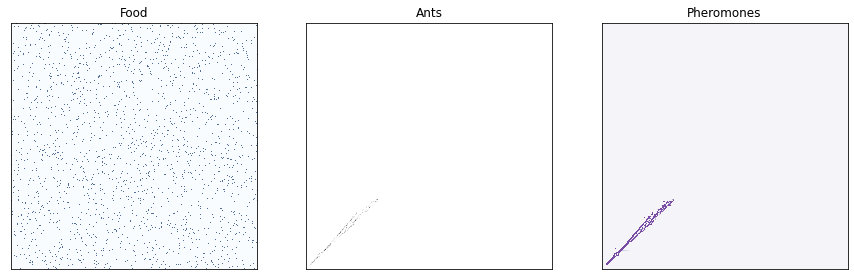

In [211]:
env.draw_verbose()

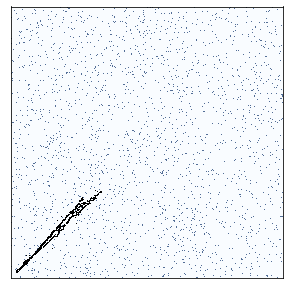

In [212]:
env.animate(100)

In [244]:
class TwoColonies(Cell2D):
    def __init__(self, n, **params):
        """
        Requires some common elements in antscapes (such as size)
        """
        self.n = n
        # environment food capacity and probability of spawning variables
        self.food_capacity = params.get('food_capacity', 400)
        self.food_generation_prob = params.get('food_generation_prob', 0.95)
        self.ants_per_cell = params.get('ants_per_cell', 10)

        self.env1 = Antscape(n, starting_ants=20, ants_per_cell=self.ants_per_cell, ants_per_step=2, starting_loc=(9,9), starting_dir='NE',
               sigmoid_offset=2, nest_size=2000, p_foraging=1, p_returning=5, p_decay=.95,
               plimit=100, food_generation_prob=self.food_generation_prob, food_capacity=self.food_capacity)
               
        self.env2 = Antscape(n, starting_ants=20, ants_per_cell=self.ants_per_cell, ants_per_step=2, starting_loc=(self.n-9,self.n-9), starting_dir='SW',
               sigmoid_offset=2, nest_size=2000, p_foraging=1, p_returning=5, p_decay=.95,
               plimit=100, food_generation_prob=self.food_generation_prob, food_capacity=self.food_capacity)

        self.array = self.make_env()
        self.env1.array = self.array
        self.env2.array = self.array

        #location array combined
        self.larray = self.env1.larray + self.env2.larray
        self.env1.larray = self.larray
        self.env2.larray = self.larray
        

    def make_env(self):
        """Creates a single foodmap
        """
        array = np.random.rand(self.n, self.n)
        
        # make food
        array[array >= self.food_generation_prob] = self.food_capacity
        array[array < self.food_generation_prob] = 0
                
        # TODO: improve how nests and multiple antscapes are added
        # create nests
        for env in [self.env1, self.env2]:
            if env.starting_dir == 'NE':
                array[:env.starting_loc[0]+1, :env.starting_loc[1]+1] = -1
            elif env.starting_dir == 'SW':
                array[env.starting_loc[0]:, env.starting_loc[1]:] = -1
                
        return array

    def step(self):
        """ Randomly selects one colony to step, then updates the array
        of the other colony, then the second colony steps and updates
        the first colony
        """
        random_order = np.random.permutation([self.env1, self.env2])
        random_order[0].step()
        self.array = random_order[0].array
        self.larray = random_order[0].larray
        random_order[1].array = self.array
        random_order[1].larray = self.larray

        random_order[1].step()
        self.array = random_order[1].array
        self.larray = random_order[1].larray
        random_order[0].array = self.array
        random_order[0].larray = self.larray
        
        
    def draw(self):
        """Draws the cells."""
        plt.figure(figsize=(5,5))
        draw_array(self.array, cmap='Blues', vmax=10, origin='lower')
        # draw occupied cells
        locs1 = [ant.loc for ant in self.env1.agents]
        xs1, ys1 = self.get_coords(locs1)
        self.points1 = plt.plot(xs1, ys1, ',', color='red')[0]

        locs2 = [ant.loc for ant in self.env2.agents]
        xs2, ys2 = self.get_coords(locs2)
        self.points2 = plt.plot(xs2, ys2, ',', color='black')[0]
        
    def draw_verbose(self):
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1), plt.title("Food")
        draw_array(self.array, cmap='Blues', vmax=3, origin='lower')
        plt.subplot(1,3,2), plt.title("Ants")
        draw_array(self.larray, cmap="Greys", vmax=self.ant_per_cell_max, origin='lower')
        plt.subplot(1,3,3), plt.title("Pheromones")
        draw_array(self.parray, cmap='Purples', vmax=10, origin='lower')
        
        
    def get_coords(self, locs):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        locs = list(locs)
        rows, cols = np.transpose(locs)
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys
        

In [245]:
multi = TwoColonies(500, food_capacity=100, food_generation_prob=0.97, ants_per_cell=5)

/tmp/ipykernel_4970/3310669261.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

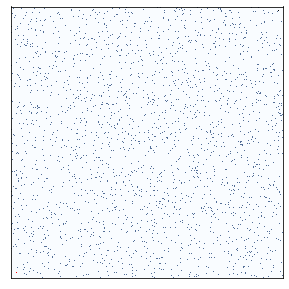

<Figure size 432x288 with 0 Axes>

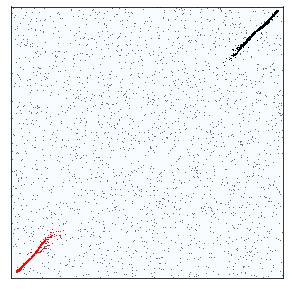

<Figure size 432x288 with 0 Axes>

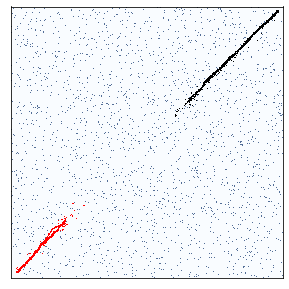

<Figure size 432x288 with 0 Axes>

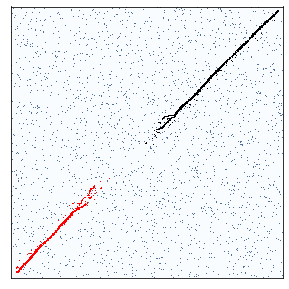

<Figure size 432x288 with 0 Axes>

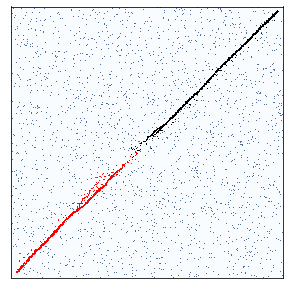

<Figure size 432x288 with 0 Axes>

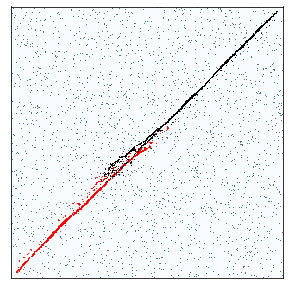

<Figure size 432x288 with 0 Axes>

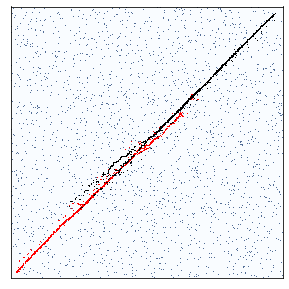

<Figure size 432x288 with 0 Axes>

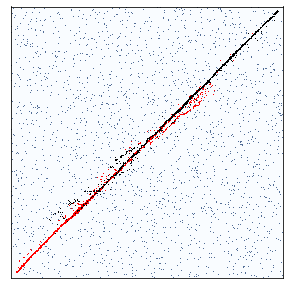

<Figure size 432x288 with 0 Axes>

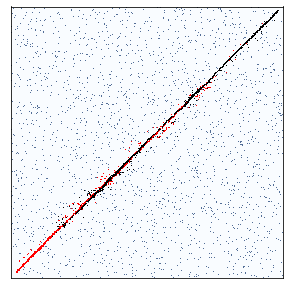

<Figure size 432x288 with 0 Axes>

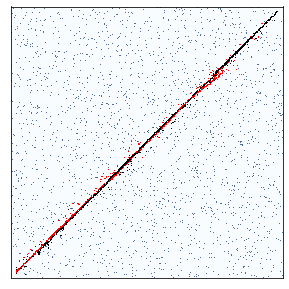

<Figure size 432x288 with 0 Axes>

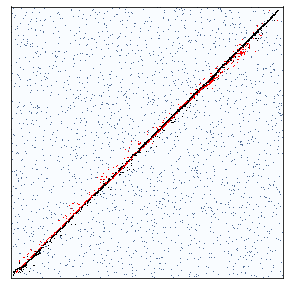

<Figure size 432x288 with 0 Axes>

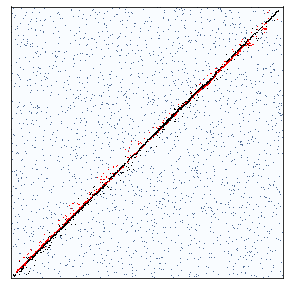

<Figure size 432x288 with 0 Axes>

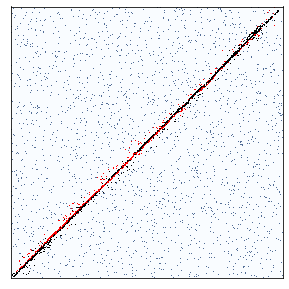

<Figure size 432x288 with 0 Axes>

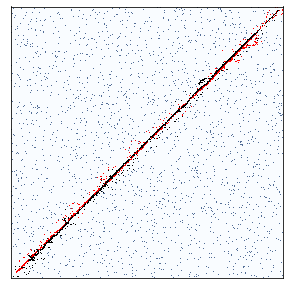

<Figure size 432x288 with 0 Axes>

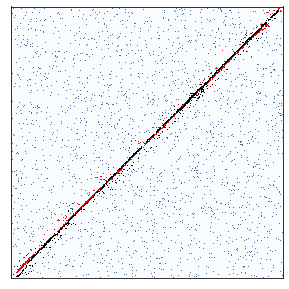

<Figure size 432x288 with 0 Axes>

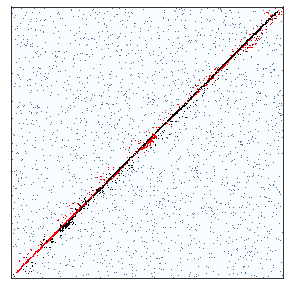

<Figure size 432x288 with 0 Axes>

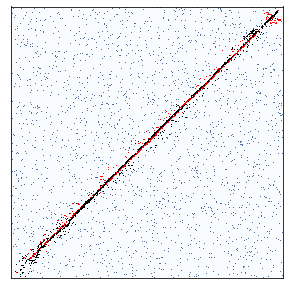

<Figure size 432x288 with 0 Axes>

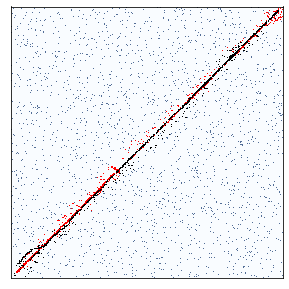

<Figure size 432x288 with 0 Axes>

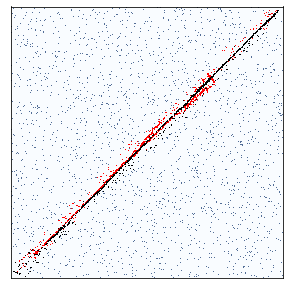

<Figure size 432x288 with 0 Axes>

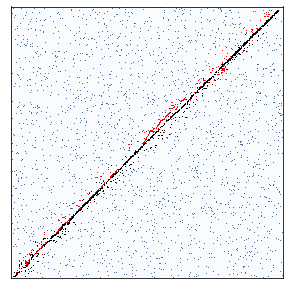

In [246]:
for i in range(10000):
    multi.step()
    if i%500 == 0:
        plt.figure()
        multi.draw()
        plt.savefig('multiant' + str(i) + '.png')


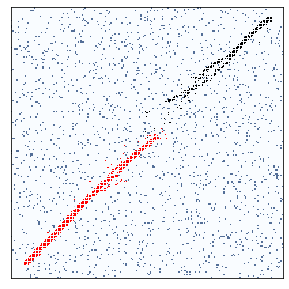

In [242]:
multi.animate(200)